In [5]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import torchvision.datasets as datasets
from PIL import Image
from read_inputs import read_transform_inputs
from utility_fun import *
import matplotlib.pyplot as plt
from gradcam.visualize import VisualizeCam
from train import *
from lrtest.lr_range_test import LRRangeFinder
from lrtest.lr_cycle_plot import LRCyclePlot

In [6]:
data_dir = "D:\\Assignment_ML_Engineer\\EVA_4.0\\S12\\data\\tiny-imagenet-200\\"

In [7]:
data_transforms = { 'train': transforms.Compose([transforms.ToTensor()]),
                    'val'  : transforms.Compose([transforms.ToTensor(),]) }
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128, shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [20]:
from model.model import ResNet,BasicBlock,Bottleneck
model_s = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)

In [24]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
trainloader = dataloaders['train']
testloader = dataloaders['val']

In [25]:
##LR Finder
lr_finder = LRRangeFinder(model_s, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, testloader, start_lr=1e-4, end_lr=0.05,
                     epochs=10, step_mode="linear")

  0%|          | 0/10 [00:06<?, ?it/s]


BrokenPipeError: [Errno 32] Broken pipe

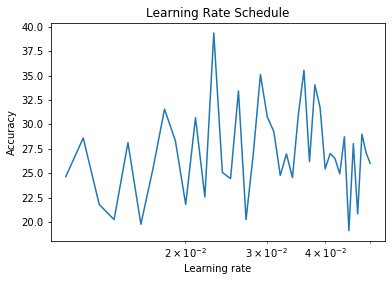

In [81]:
lr_finder.plot(metric='acc', skip_start=10, skip_end=0)
lr_finder.reset()

In [73]:
best_loss = lr_finder.best_loss
best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
print("Best Accuracy: %s\nBest Learning Rate: %s" % (best_loss, best_lr))

Best Accuracy: 0.016617268908023834
Best Learning Rate: 0.026050552429667518


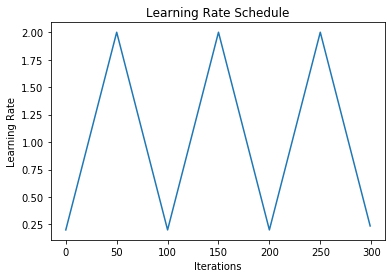

<Figure size 432x288 with 0 Axes>

In [74]:
lrplt = LRCyclePlot({})
lrplt("lr_cycle_plot_test.png")

In [75]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = OneCycleLR(optimizer, max_lr=best_lr, steps_per_epoch=len(trainloader),
                       epochs=24, div_factor=5, final_div_factor=1,
                       pct_start=0.2, anneal_strategy="linear")

In [76]:
clf = training_class(model = model,trainloader = trainloader, testloader = testloader, device = device, epoch= 24, optimizer = optimizer, criterion = criterion ,l1 = 0 , l2 = 0,scheduler=scheduler)
train_acc,test_acc = clf.fit()
model_f = clf.give_model()

epoch [0] train accuracy 0.734 : test accuracy 0.743
epoch [1] train accuracy 0.779 : test accuracy 0.773
epoch [2] train accuracy 0.829 : test accuracy 0.809
epoch [3] train accuracy 0.844 : test accuracy 0.823
epoch [4] train accuracy 0.839 : test accuracy 0.818
epoch [5] train accuracy 0.887 : test accuracy 0.858
epoch [6] train accuracy 0.890 : test accuracy 0.855
epoch [7] train accuracy 0.912 : test accuracy 0.872
epoch [8] train accuracy 0.905 : test accuracy 0.867
epoch [9] train accuracy 0.917 : test accuracy 0.877
epoch [10] train accuracy 0.917 : test accuracy 0.872
epoch [11] train accuracy 0.933 : test accuracy 0.879
epoch [12] train accuracy 0.935 : test accuracy 0.882
epoch [13] train accuracy 0.943 : test accuracy 0.887
epoch [14] train accuracy 0.933 : test accuracy 0.881
epoch [15] train accuracy 0.948 : test accuracy 0.893
epoch [16] train accuracy 0.947 : test accuracy 0.885
epoch [17] train accuracy 0.952 : test accuracy 0.889
epoch [18] train accuracy 0.959 : test

In [77]:
torch.save(model_f, "model.sav")

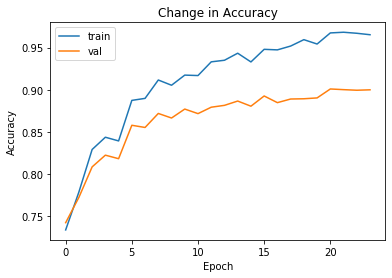

In [78]:
plt_data = {
    "train": train_acc,
    "val": test_acc
}
plot_graph(plt_data, "Accuracy")

In [79]:
##Test Loop
testloss,test_check =  truth_checker(model, testloader, device,criterion)

In [80]:
print("Test Accuracy: %s\n" % (test_check))

Test Accuracy: 0.9

